# Necessary Imports

In [7]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed 
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Loading Dataset

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/Diabetic Rentinopathy/aptos_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Diabetic Rentinopathy/aptos_data/test.csv')

In [10]:
print('Number of train samples: ', train_df.shape[0])
print('Number of test samples: ', test_df.shape[0])
# display(train_df.head())

Number of train samples:  3662
Number of test samples:  1928


## Visualize Class Distribution

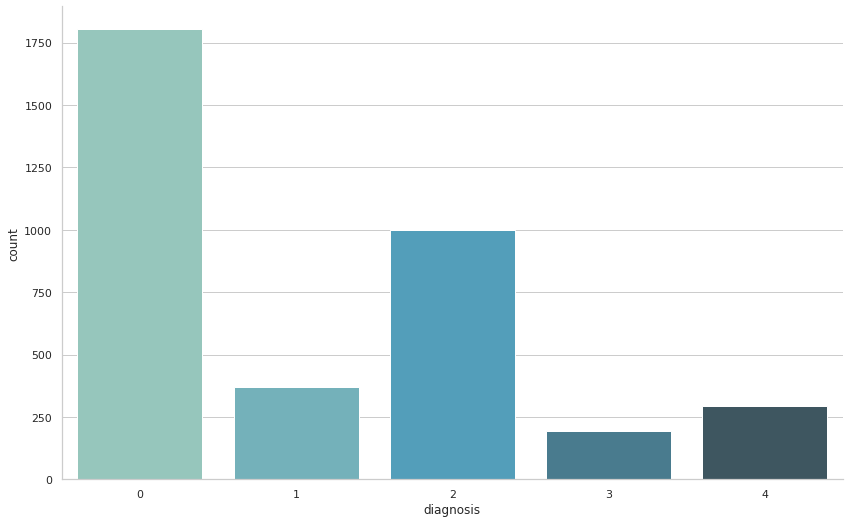

In [11]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train_df, palette="GnBu_d")
sns.despine()
plt.show()

Label Mapping

    0 - No DR
    1 - Mild
    2 - Moderate
    3 - Severe
    4 - Proliferative DR

## Visualize Sample Data

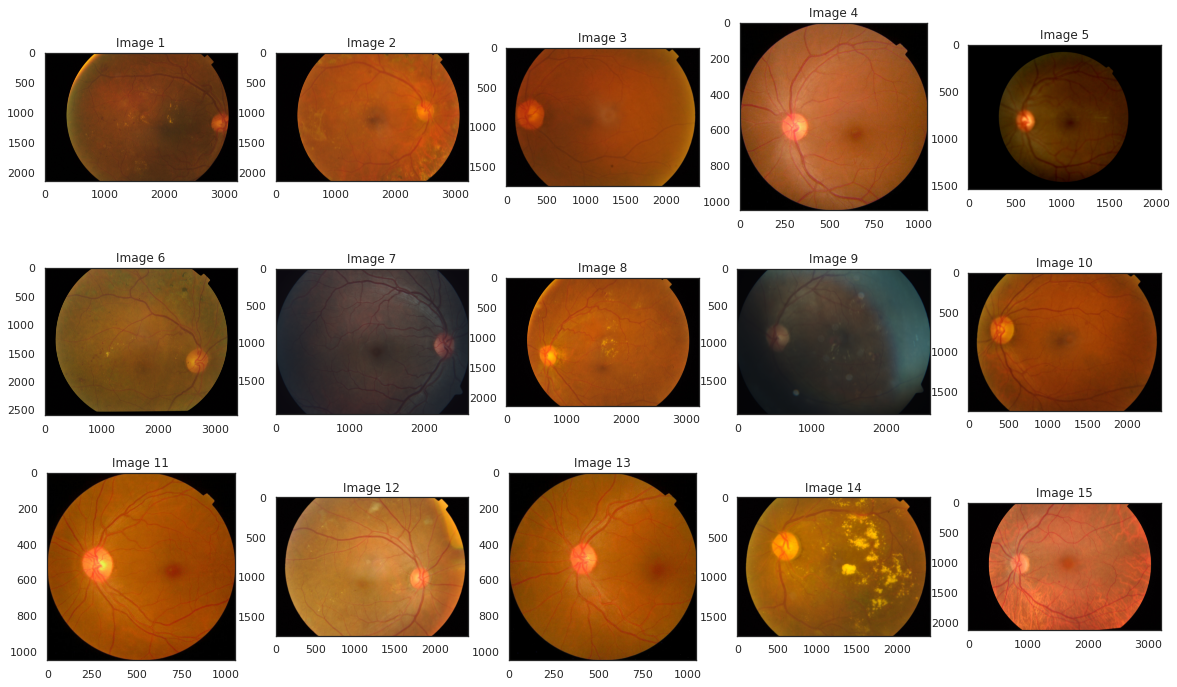

In [13]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train_df['id_code'][:15]:
    img = cv2.imread("/content/drive/MyDrive/Diabetic Rentinopathy/aptos_data/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

# Image Processing

- Reducing `lighting condition` effects
- Cropping to remove uninformative area

In [14]:
IMG_SIZE = 512
SEED = 77

## Cropping Function

In [15]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            # print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
            # print(img.shape)
        return img

## Improving Lighting Condition

In [16]:
def load_color_correction(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

## Visualize some processed Image

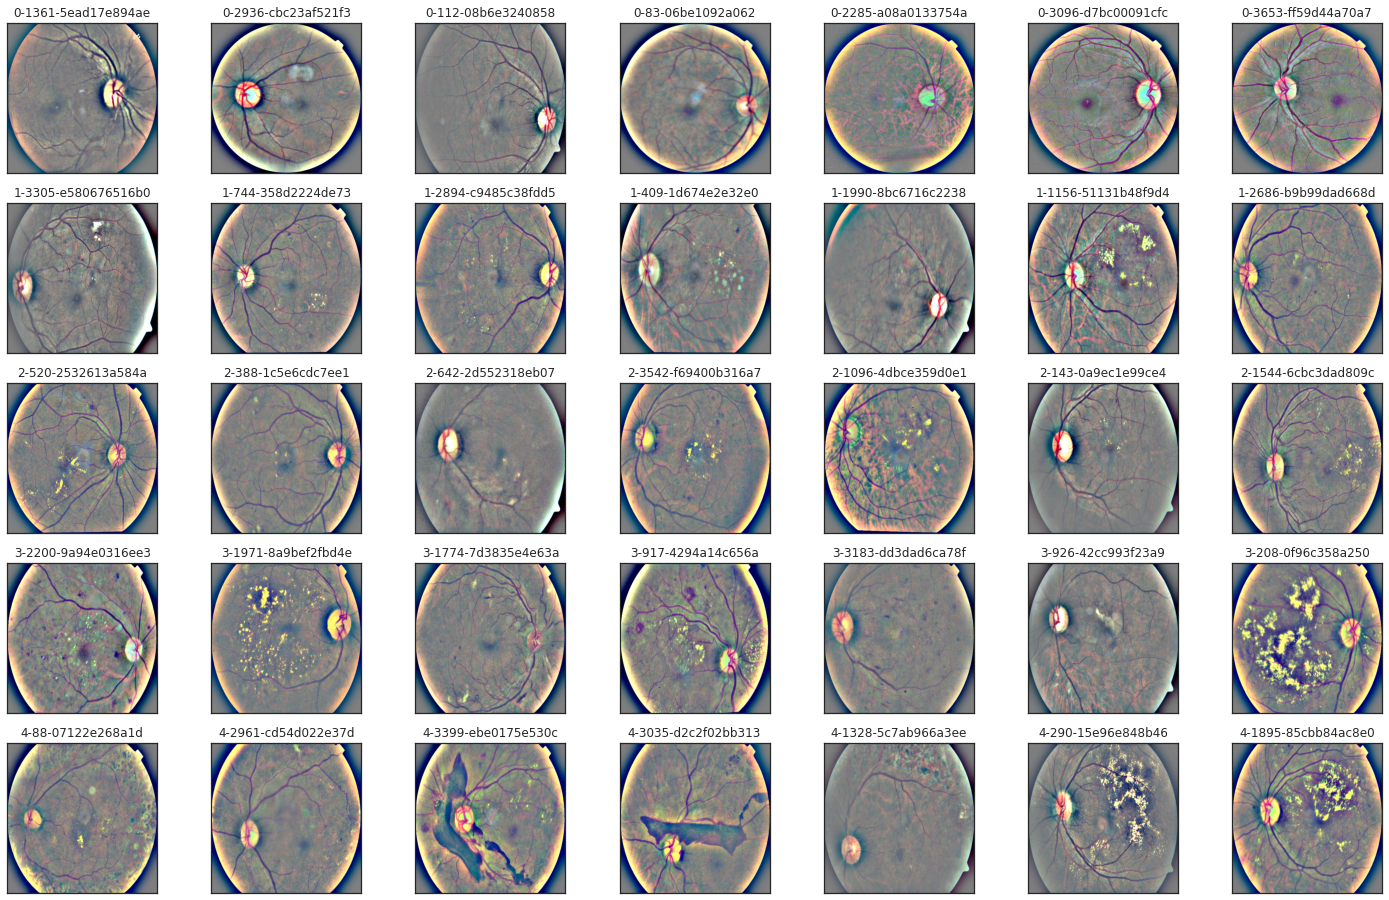

In [18]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in train_df['diagnosis'].unique():
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/MyDrive/Diabetic Rentinopathy/aptos_data/train_images/{row['id_code']}.png"
        image = load_color_correction(path,sigmaX=20)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

Observation:

- Lighting condition improved
- Need to modify the cropping function (as roi getting cropped)

## Function for (lighting condition + Circle crop)

In [19]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

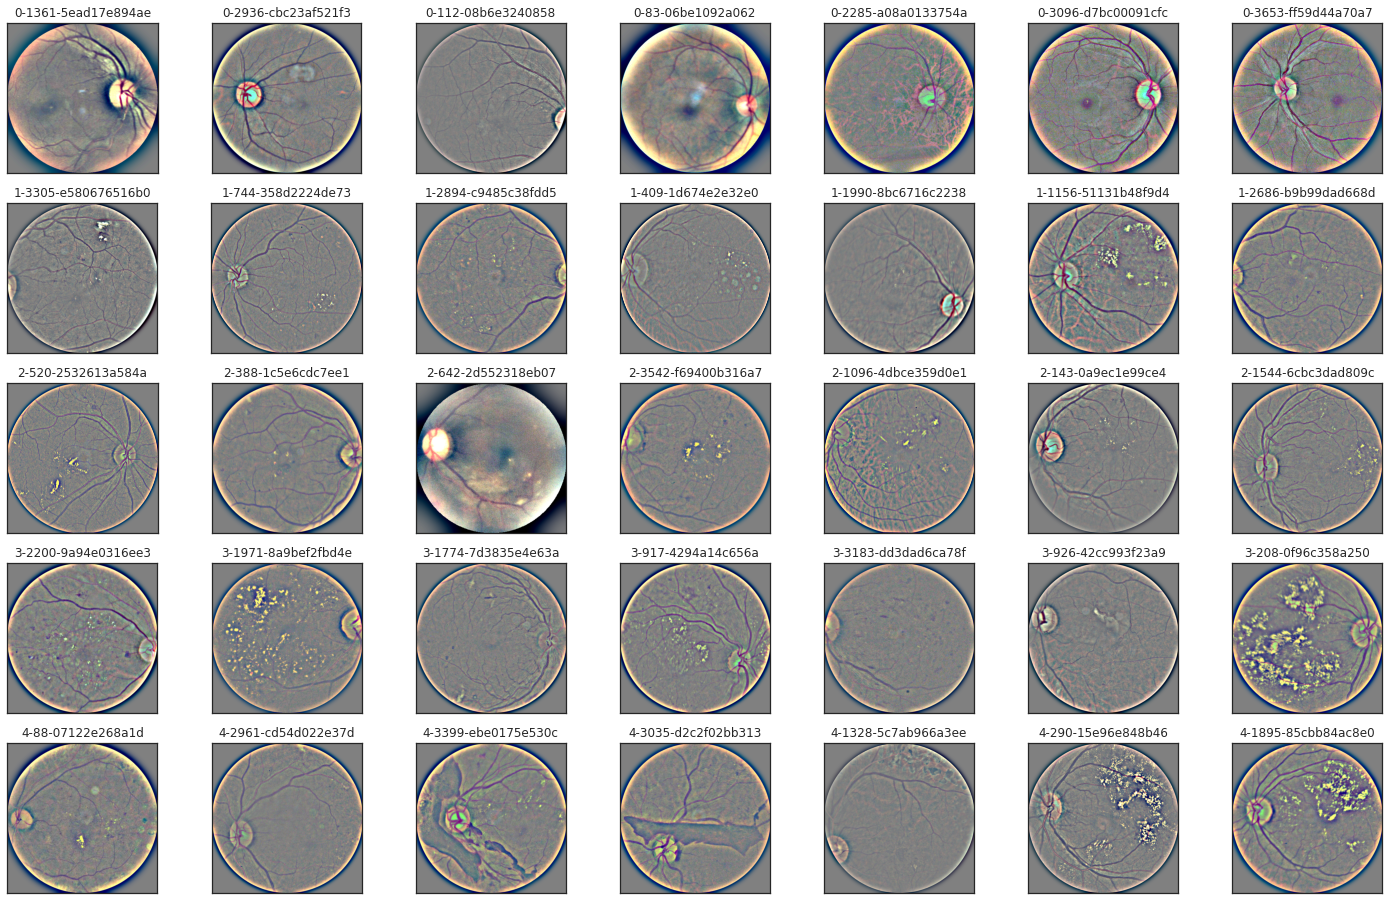

In [22]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in train_df['diagnosis'].unique():
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/MyDrive/Diabetic Rentinopathy/aptos_data/train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

# Saving Processed Data

### Path Declaration

In [23]:
train_source_path = '/content/drive/MyDrive/Diabetic Rentinopathy/aptos_data/train_images/'
test_source_path = '/content/drive/MyDrive/Diabetic Rentinopathy/aptos_data/test_images/'

train_dest_path = "/content/drive/MyDrive/Diabetic Rentinopathy/dataset/train_images/"
test_dest_path = "/content/drive/MyDrive/Diabetic Rentinopathy/dataset/test_images/"

### Applying preprocessing & Saving images

In [31]:
def process_image_folder(df,source_path,dest_path):
    for i,(idx,row) in enumerate(df.iterrows()):
        img_path=f"{source_path}{row['id_code']}.png"
        dest_img_path = f"{dest_path}{row['id_code']}.png"
        image = circle_crop(img_path,sigmaX=30)
        # plt.axis('off')
        # plt.imshow(image)
        # plt.savefig(dest_img_path)
        cv2.imwrite(dest_img_path,image)


In [32]:
process_image_folder(train_df,train_source_path,train_dest_path)

In [33]:
process_image_folder(test_df,test_source_path,test_dest_path)